In [21]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T

from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from einops import rearrange

from src.autoencoders import Autoencoder

# Fix random seed
torch.manual_seed(0)
random.seed(0)

In [42]:
# Visualize image space

def load_fashionmnist(root):
    dataset = FashionMNIST(root=root, train=True, download=True)
    examples, targets = dataset.data, dataset.targets
    examples = examples.float() / 255.0 
    examples = rearrange(examples, 'n h w -> n (h w)')
    return examples, targets

x_image, y = load_fashionmnist('data')
x_image = x_image.numpy()
y = y.numpy()

# Because 60,000 points are too many, we will perform random sampling for visualization
idx = [i for i in range(60000)]
random.shuffle(idx)
idx = idx[:6000]
x_image = x_image[idx, :]
y = y[idx]

z_image = TSNE(n_components=2, perplexity=20).fit_transform(x_image)

/home/hukim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hukim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


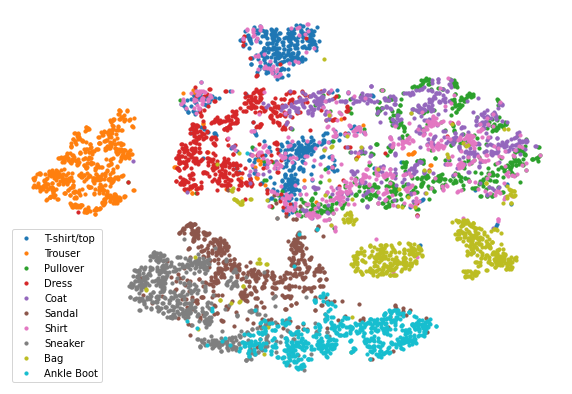

In [43]:
labels = ['T-shirt/top',
          'Trouser',
          'Pullover',
          'Dress',
          'Coat',
          'Sandal',
          'Shirt',
          'Sneaker',
          'Bag',
          'Ankle Boot']

colors = ['tab:blue', 
          'tab:orange',
          'tab:green',
          'tab:red',
          'tab:purple',
          'tab:brown',
          'tab:pink',
          'tab:gray',
          'tab:olive',
          'tab:cyan']
# print(type(y), y.dtype)
# l = labels[y]

plt.figure(figsize=(10,7))

for i in range(10):
    k = np.where(y==i)[0]
    plt.scatter(z_image[k, 0], z_image[k, 1], c=colors[i], s=10, label=labels[i])

# plt.scatter(z_image[:, 0], z_image[:, 1], c=y, s=10)
plt.axis("off")
plt.legend(labels, loc='best')
plt.show()

In [44]:
# Visualize latent space

def extract_feature(loader, model, device):
    model.eval()
    features = torch.empty((0, 100), dtype=torch.float32)
    labels = torch.empty((0, ), dtype=torch.long)
    for image, label in loader:
        image = image.to(device)
        with torch.no_grad():
            feature, _ = model(image)
        feature = feature.to('cpu')
        features = torch.cat([features, feature], dim=0)
        labels = torch.cat([labels, label], dim=0)
    return features, labels

transform = T.Compose([T.ToTensor()])
dataset = FashionMNIST('data', train=True, download=True, transform=transform)
loader = DataLoader(dataset, 100, shuffle=False, num_workers=8)

model = Autoencoder()
model = model.to('cuda:0')

checkpoint_path = 'checkpoints/autoencoder.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model'])

x_latent, y  = extract_feature(loader, model, 'cuda:0')
x_latent = x_latent.numpy()
y = y.numpy()

x_latent = x_latent[idx, :]
y = y[idx]

/home/hukim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hukim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


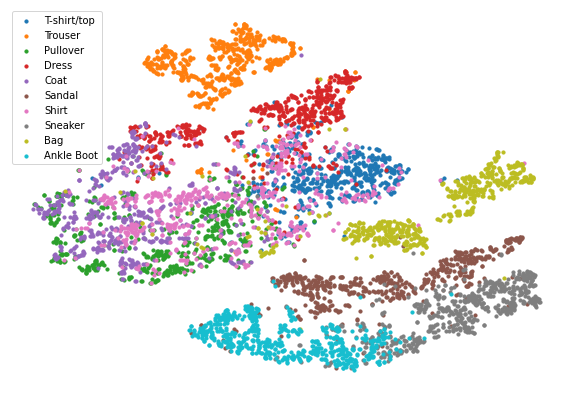

In [47]:
z_latent = TSNE(n_components=2, perplexity=20).fit_transform(x_latent)

plt.figure(figsize=(10,7))

for i in range(10):
    k = np.where(y==i)[0]
    plt.scatter(z_latent[k, 0], z_latent[k, 1], c=colors[i], s=10, label=labels[i])
plt.axis("off")
plt.legend(labels, loc='best')
plt.show()